<a href="https://colab.research.google.com/github/charlottevedrines/Python-Projects/blob/main/Lab2_Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission: https://drive.google.com/file/d/1f4ZLlLIPZCPWOdaObFnobdnff_w8HiK9/view?usp=sharing

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link:

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [2]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [3]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

100%|██████████| 170498071/170498071 [00:13<00:00, 13114864.86it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

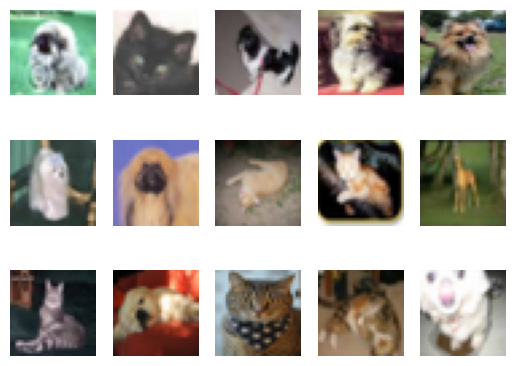

In [4]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [5]:
target_classes = ['cat', 'dog']

relevant_indices = get_relevant_indices(train_loader.dataset, classes, target_classes)

print("Number of training examples for cat and dog classes combined: ", len(relevant_indices))

Number of training examples for cat and dog classes combined:  10000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

Answer: If we judge the performance of the model only using the training set loss we risk to prolong training until the model score perfectly well on the datatset, resulting the model to overfit on the dataset. The validation counters allows to evaluate the model on unseen data, therefore making the model more robust and less prone to overfitting. The validation set also allows for an accurate projection of the performance of the model when it will be deployed in the real world.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [6]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [7]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [8]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [9]:
temp = 0

for param in small_net.parameters():
   # print(param.shape)
    temp += param.numel()

print("The total number of parameters in small_net are: ", temp)

temp2 = 0
for param in large_net.parameters():
   # print(param.shape)
    temp2 += param.numel()

print("The total number of parameters in large_net are: ", temp2)

The total number of parameters in small_net are:  386
The total number of parameters in large_net are:  9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [10]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

Answer: The default values of batch_size is 64, learning_rate is 0.01 and num_epochs is 30.

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list of all the files written to disk, and what information the files contain.

Answer: for each epoch a model checkpoint is saved with the helper function `get_model_name()` which saves the name of the model, the batch size, the learning parameter and epoch number.  The list of would be

small_batch64_lr0.01_epoch0 \
small_batch64_lr0.01_epoch1\
small_batch64_lr0.01_epoch2\
small_batch64_lr0.01_epoch3\
small_batch64_lr0.01_epoch4

Additionally, the train/test loss/err are saved into CSV file for plotting later using the `np.savetxt()` function. For each epoch a corresponding entry in the CSV is saved for training error, training loss, validation error and validation loss.
\
small_batch64_lr0.01_epoch4_train_err.csv\
small_batch64_lr0.01_epoch4_train_loss.csv\
small_batch64_lr0.01_epoch4_val_err.csv\
small_batch64_lr0.01_epoch4_val_loss.csv

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [11]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
train_net(small_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.434125, Train loss: 0.6824219102859497 |Validation err: 0.3805, Validation loss: 0.6632561273872852
Epoch 2: Train err: 0.371625, Train loss: 0.6503590908050537 |Validation err: 0.3745, Validation loss: 0.6579374894499779
Epoch 3: Train err: 0.35425, Train loss: 0.6354560475349427 |Validation err: 0.3565, Validation loss: 0.6273502968251705
Epoch 4: Train err: 0.342375, Train loss: 0.6220643663406372 |Validation err: 0.364, Validation loss: 0.6282271258533001
Epoch 5: Train err: 0.332125, Train loss: 0.6130362901687622 |Validation err: 0.3345, Validation loss: 0.6153980027884245
Epoch 6: Train err: 0.326, Train loss: 0.6040825028419494 |Validation err: 0.338, Validation loss: 0.6173650119453669
Epoch 7: Train err: 0.320625, Train loss: 0.5997691521644593 |Validation err: 0.331, Validation loss: 0.6068235989660025
Epoch 8: Train err: 0.315875, Train loss: 0.592007560968399 |Validation err: 

In [13]:
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.495, Train loss: 0.6933774042129517 |Validation err: 0.4385, Validation loss: 0.6913973540067673
Epoch 2: Train err: 0.45825, Train loss: 0.6893001189231872 |Validation err: 0.4295, Validation loss: 0.6834072917699814
Epoch 3: Train err: 0.430875, Train loss: 0.6800888633728027 |Validation err: 0.398, Validation loss: 0.6669717878103256
Epoch 4: Train err: 0.39375, Train loss: 0.6655389657020568 |Validation err: 0.368, Validation loss: 0.6527992468327284
Epoch 5: Train err: 0.377625, Train loss: 0.6524533357620239 |Validation err: 0.365, Validation loss: 0.6384348683059216
Epoch 6: Train err: 0.354875, Train loss: 0.6337761483192443 |Validation err: 0.3605, Validation loss: 0.6322413869202137
Epoch 7: Train err: 0.343125, Train loss: 0.6223661293983459 |Validation err: 0.3255, Validation loss: 0.6156336385756731
Epoch 8: Train err: 0.332875, Train loss: 0.6073305180072784 |Validation err: 

The small model took 119.13 seconds and the large model took 131.46 seconds. The large model took more time to train because it contains more parameters.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

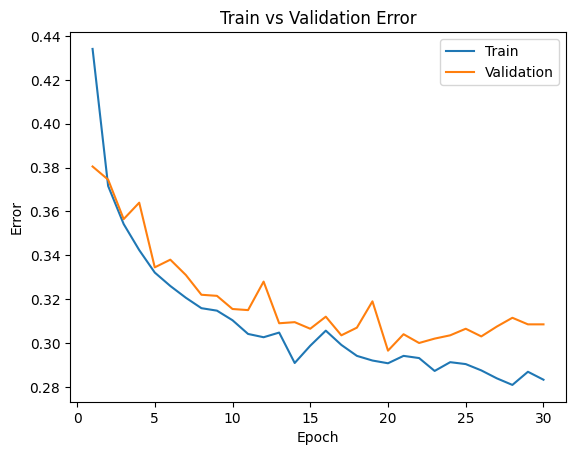

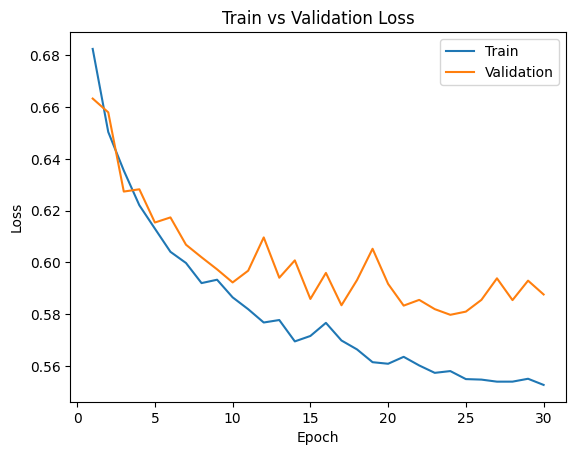

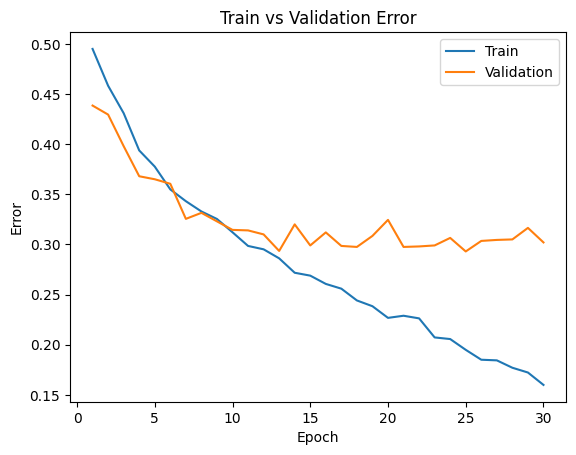

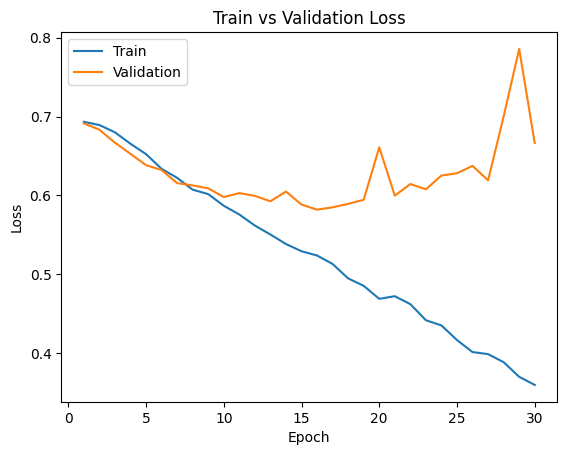

In [14]:
small_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
large_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)

plot_training_curve(small_path)
plot_training_curve(large_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

The error and loss for the large network increase for both validation and training decrease up to about 5 epochs, after that the validation loss and error show signs of overfitting.

Similarily, the small network, exhibits signs of overfitting where the validation set displays higher loss/error than the training, however this occurs faster than for the large model.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [15]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate = 0.001)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360004425049 |Validation err: 0.467, Validation loss: 0.692468661814928
Epoch 2: Train err: 0.448625, Train loss: 0.6922589693069457 |Validation err: 0.4305, Validation loss: 0.6916493456810713
Epoch 3: Train err: 0.43575, Train loss: 0.6916067309379578 |Validation err: 0.4285, Validation loss: 0.6908544600009918
Epoch 4: Train err: 0.43, Train loss: 0.6908613452911377 |Validation err: 0.424, Validation loss: 0.6896595284342766
Epoch 5: Train err: 0.434125, Train loss: 0.6899194993972778 |Validation err: 0.4195, Validation loss: 0.6886935140937567
Epoch 6: Train err: 0.43575, Train loss: 0.6887412719726562 |Validation err: 0.4195, Validation loss: 0.686782693490386
Epoch 7: Train err: 0.436875, Train loss: 0.6873777813911438 |Validation err: 0.4185, Validation loss: 0.6851987447589636
Epoch 8: Train err: 0.437375, Train loss: 0.68592657995224 |Validation err: 0.411

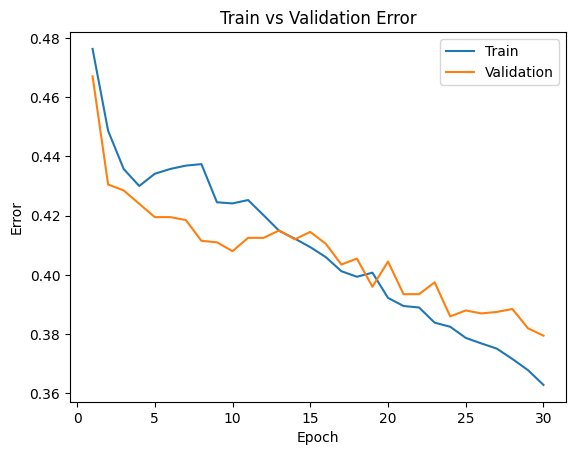

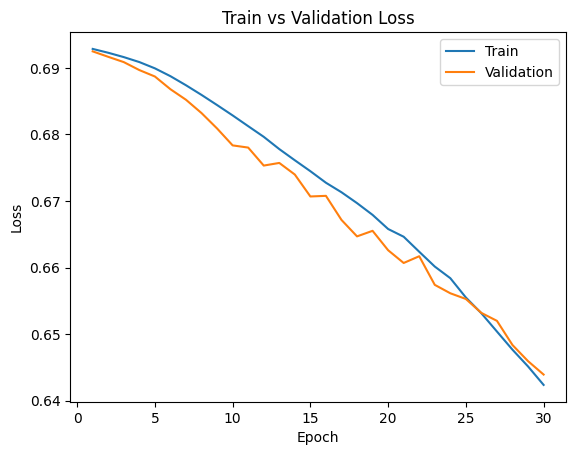

In [16]:
large_net_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(large_net_path)

The large model takes 131.50 seconds to train which is slighly more than what was needed before lowering the learning rate. Lowering the learning rate lowers the step size in gradient descent therefore prolonging the time to finding the optimum. We can observe from the graphs that there is a overfitting that starts to occur at 25 epochs.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [17]:
large_net = LargeNet()
train_net(large_net, learning_rate = 0.1)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4275, Train loss: 0.6742977557182313 |Validation err: 0.3765, Validation loss: 0.637031726539135
Epoch 2: Train err: 0.368375, Train loss: 0.6400856471061707 |Validation err: 0.355, Validation loss: 0.6248273365199566
Epoch 3: Train err: 0.357, Train loss: 0.6258103721141816 |Validation err: 0.3435, Validation loss: 0.6111582862213254
Epoch 4: Train err: 0.348625, Train loss: 0.6193035736083984 |Validation err: 0.3445, Validation loss: 0.6090600341558456
Epoch 5: Train err: 0.330875, Train loss: 0.6069964549541473 |Validation err: 0.3205, Validation loss: 0.5968910921365023
Epoch 6: Train err: 0.31825, Train loss: 0.5847644207477569 |Validation err: 0.3175, Validation loss: 0.6014995649456978
Epoch 7: Train err: 0.310125, Train loss: 0.5844504678249359 |Validation err: 0.32, Validation loss: 0.5886365948244929
Epoch 8: Train err: 0.298875, Train loss: 0.5663281772136688 |Validation err: 0.

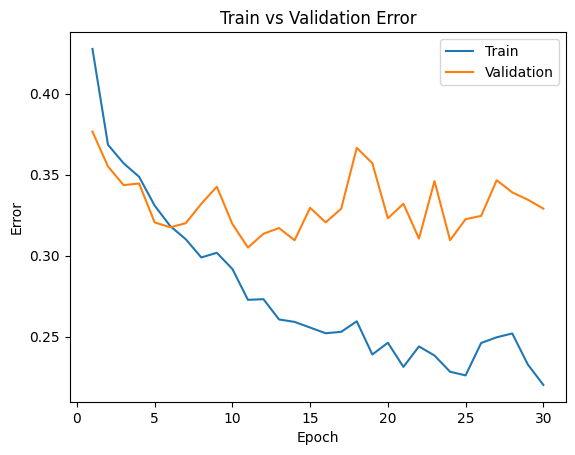

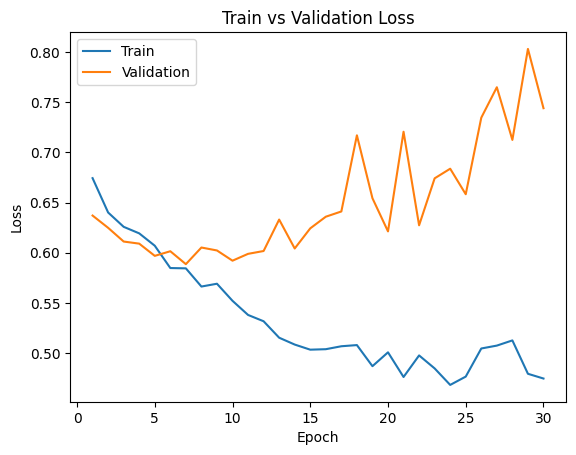

In [18]:

large_net_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(large_net_path)

The model took 145.19 seconds, which is about the higher as training the model with a smaller step size. Indeed, after a couple epochs, the validation set's error and loss increase instead of decreasing exhibiting signs of overfitting very early on.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379589855671 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500627994537 |Validation err: 0.4265, Validation loss: 0.6909130364656448
Epoch 4: Train err: 0.433625, Train loss: 0.6908450126647949 |Validation err: 0.424, Validation loss: 0.6897871196269989
Epoch 5: Train err: 0.434, Train loss: 0.6896936185657978 |Validation err: 0.424, Validation loss: 0.6881358623504639
Epoch 6: Train err: 0.43825, Train loss: 0.6883535124361515 |Validation err: 0.4285, Validation loss: 0.6860134303569794
Epoch 7: Train err: 0.43925, Train loss: 0.6866881102323532 |Validation err: 0.426, Validation loss: 0.6836976855993271
Epoch 8: Train err: 0.43525, Train loss: 0.6849788911640644 |Validation err: 0.412, 

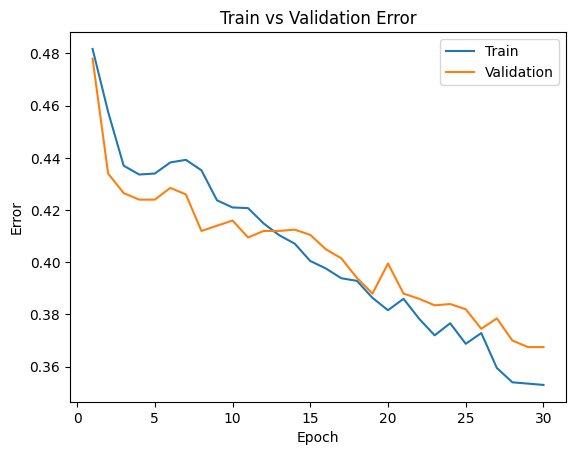

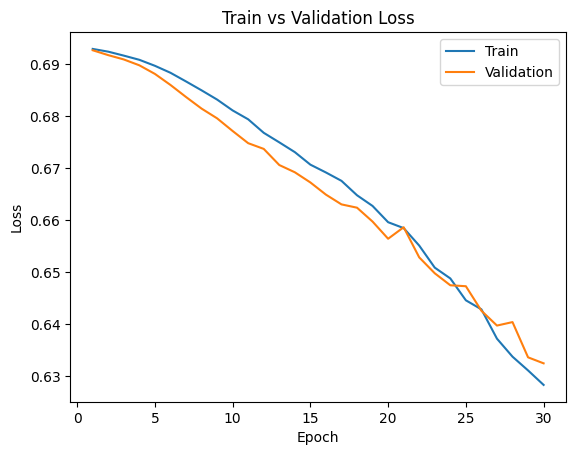

In [19]:
large_net = LargeNet()
train_net(large_net, batch_size=512)
large_net_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(large_net_path)

The model takes 120.24 s to train which is less time than training the model with a step size of either 0.001 or 0.1. There are no signs of overfitting but there signs of underfitting because it seems that the model could benefit of some more training time to further decrease the loss/error.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.432625, Train loss: 0.6775506143569946 |Validation err: 0.378, Validation loss: 0.6512572016716004
Epoch 2: Train err: 0.365625, Train loss: 0.6391648109555245 |Validation err: 0.3445, Validation loss: 0.6164793195724487
Epoch 3: Train err: 0.342, Train loss: 0.615125280380249 |Validation err: 0.336, Validation loss: 0.6379956271648407
Epoch 4: Train err: 0.314125, Train loss: 0.5860003967881202 |Validation err: 0.3415, Validation loss: 0.6001057887077331
Epoch 5: Train err: 0.301, Train loss: 0.5655734968781472 |Validation err: 0.2985, Validation loss: 0.5773719894886017
Epoch 6: Train err: 0.285125, Train loss: 0.5443512220978737 |Validation err: 0.294, Validation loss: 0.5772788987159729
Epoch 7: Train err: 0.27, Train loss: 0.527300390958786 |Validation err: 0.284, Validation loss: 0.5634327321052551
Epoch 8: Train err: 0.25625, Train loss: 0.5123887897133828 |Validation err: 0.2965, V

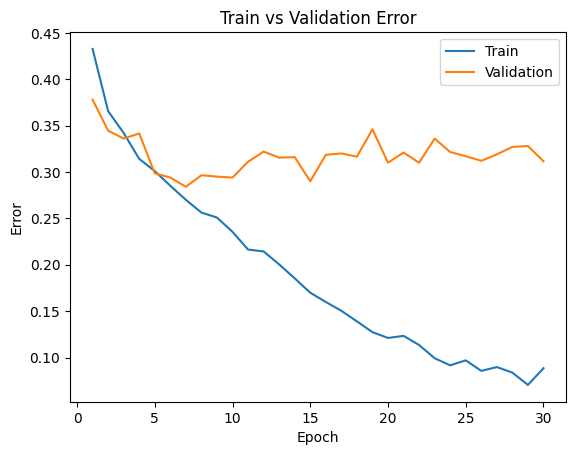

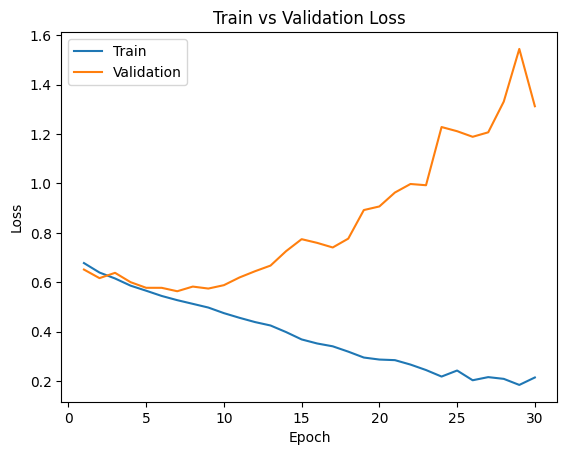

In [20]:
large_net = LargeNet()
train_net(large_net, batch_size=16)
large_net_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(large_net_path)

The model took 209.64 s for training which is much longer than what the previous model took for training. Decreasing the batch size seems has decreased the error and training loss on both the validation and loss compared to the previous example. However, after 5 epochs the model starts to overfit significantly.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

The chosen set of values for hyperparameters is a batch size of 512 and 100 epochs. In Part 3 section (c) increasing the batch size to 512 yield the best results without overfitting. By 30 epoches the training loss was still decreasing suggesting that to add epochs would improve results which is why I chose to increase the number of epochs for this model. Reducing the learning rate also improved results so I set the learning rate to 0.001.

In [21]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.001, num_epochs = 40)
large_net_path = get_model_name("large", batch_size=512, learning_rate=0.001, epoch=39)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48825, Train loss: 0.6930677443742752 |Validation err: 0.4955, Validation loss: 0.6931362152099609
Epoch 2: Train err: 0.483125, Train loss: 0.6929955147206783 |Validation err: 0.4945, Validation loss: 0.6930360496044159
Epoch 3: Train err: 0.480375, Train loss: 0.6929280422627926 |Validation err: 0.493, Validation loss: 0.6929539740085602
Epoch 4: Train err: 0.477, Train loss: 0.6928808465600014 |Validation err: 0.4885, Validation loss: 0.6928706914186478
Epoch 5: Train err: 0.473375, Train loss: 0.692774411290884 |Validation err: 0.4835, Validation loss: 0.692750483751297
Epoch 6: Train err: 0.469, Train loss: 0.692689623683691 |Validation err: 0.472, Validation loss: 0.6926551908254623
Epoch 7: Train err: 0.46325, Train loss: 0.692620363086462 |Validation err: 0.47, Validation loss: 0.6925524473190308
Epoch 8: Train err: 0.46225, Train loss: 0.6925435587763786 |Validation err: 0.463, Va

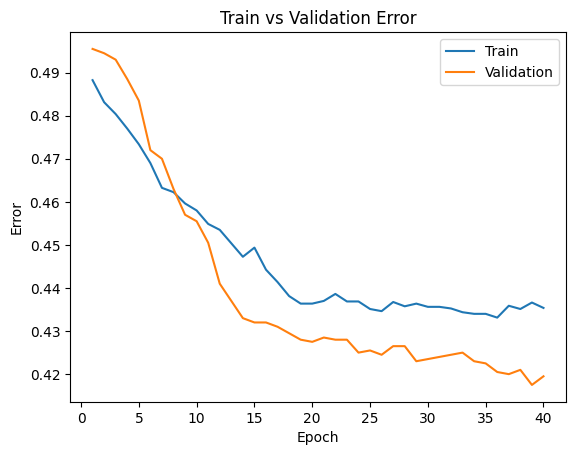

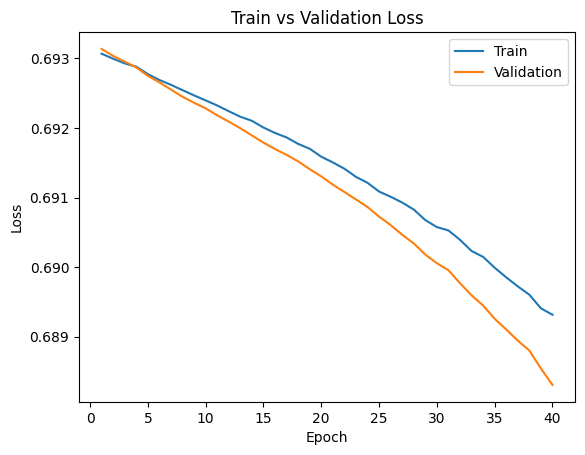

In [22]:
plot_training_curve(large_net_path)

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

See part (a)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

The model is performing well, I would increase the number of epochs because the loss and error is still decreasing after 40 epochs without showing any signs of overfitting.

In [23]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.001, num_epochs = 60)
large_net_path = get_model_name("large", batch_size=512, learning_rate=0.001, epoch=59)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.50225, Train loss: 0.6932390406727791 |Validation err: 0.491, Validation loss: 0.6925973147153854
Epoch 2: Train err: 0.50225, Train loss: 0.6931993030011654 |Validation err: 0.491, Validation loss: 0.6925128698348999
Epoch 3: Train err: 0.50225, Train loss: 0.6930338740348816 |Validation err: 0.491, Validation loss: 0.692424401640892
Epoch 4: Train err: 0.50225, Train loss: 0.6929084211587906 |Validation err: 0.491, Validation loss: 0.692307636141777
Epoch 5: Train err: 0.50225, Train loss: 0.6928513087332249 |Validation err: 0.491, Validation loss: 0.6922775954008102
Epoch 6: Train err: 0.50225, Train loss: 0.6927504986524582 |Validation err: 0.491, Validation loss: 0.6921898722648621
Epoch 7: Train err: 0.502375, Train loss: 0.6926773004233837 |Validation err: 0.49, Validation loss: 0.6921289712190628
Epoch 8: Train err: 0.50225, Train loss: 0.6925990842282772 |Validation err: 0.4895, V

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

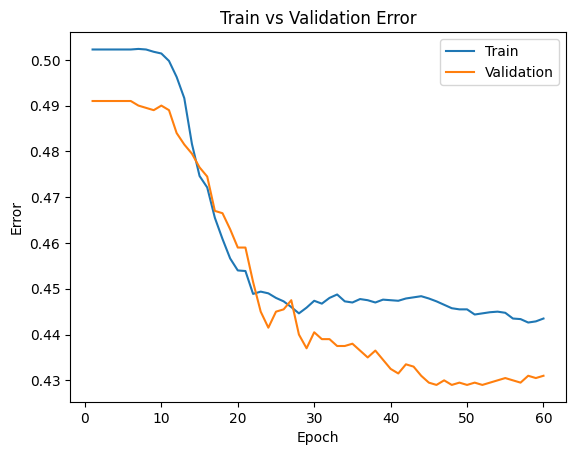

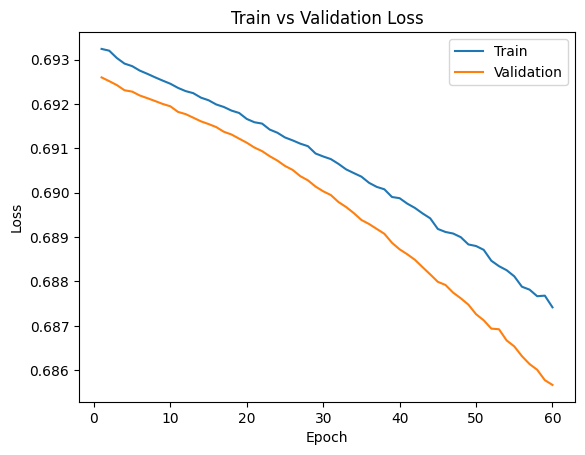

In [24]:
plot_training_curve(large_net_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [25]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=512, learning_rate=0.001, epoch=59)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

The parameters for part a are the parameters that produced the model with the lowest error, loss without exhibiting signa of overfitting or underfitting.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [26]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=512)

criterion = nn.BCEWithLogitsLoss()
testError, testLoss = evaluate(net, test_loader, criterion)

print("The error for the test set is ", testError)
print("The loss on the test set is", testLoss)

Files already downloaded and verified
Files already downloaded and verified
The error for the test set is  0.424
The loss on the test set is 0.6844466477632523


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

The error on the test set is 0.424 while the validation error is 0.431. The error test set is lower than the validation error however, we would expect the test error to be higher because the model chosen was selected because it performed well on the validation dataset. We would therefore expect that the model would perform better on the validation set than a new random set. Perhaps the data on the test set happen to be more similar to the training set compared to the validation set.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

The test set is to evaluate the performance of the model on unseen data thereby gauging how the model would perform on unseen data. It's important to use the test data as little as possible to reduce any chances of the model 'learning' from those images or that defeats the purpose of evaluating the model on unseen data.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [29]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.name = "ANN"
        self.layer1 = nn.Linear(3 * 32 * 32, 30)
        self.layer2 = nn.Linear(30, 1)
    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = x.squeeze(1)
        return x

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.511625, Train loss: 0.6978331319987774 |Validation err: 0.5005, Validation loss: 0.6952047497034073
Epoch 2: Train err: 0.464625, Train loss: 0.6903532668948174 |Validation err: 0.4555, Validation loss: 0.6882167458534241
Epoch 3: Train err: 0.440625, Train loss: 0.6840902976691723 |Validation err: 0.4365, Validation loss: 0.6832959800958633
Epoch 4: Train err: 0.423, Train loss: 0.679195199161768 |Validation err: 0.4295, Validation loss: 0.6793268322944641
Epoch 5: Train err: 0.417375, Train loss: 0.6750028692185879 |Validation err: 0.4155, Validation loss: 0.6760837882757187
Epoch 6: Train err: 0.410125, Train loss: 0.6719224564731121 |Validation err: 0.4085, Validation loss: 0.6732309609651566
Epoch 7: Train err: 0.406375, Train loss: 0.6692085117101669 |Validation err: 0.404, Validation loss: 0.6711424738168716
Epoch 8: Train err: 0.402375, Train loss: 0.666923388838768 |Validation err

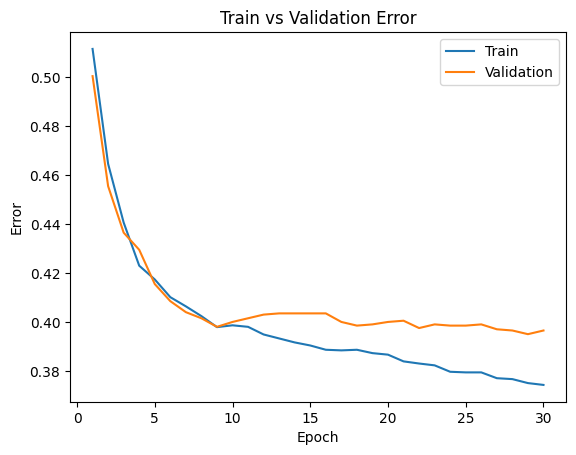

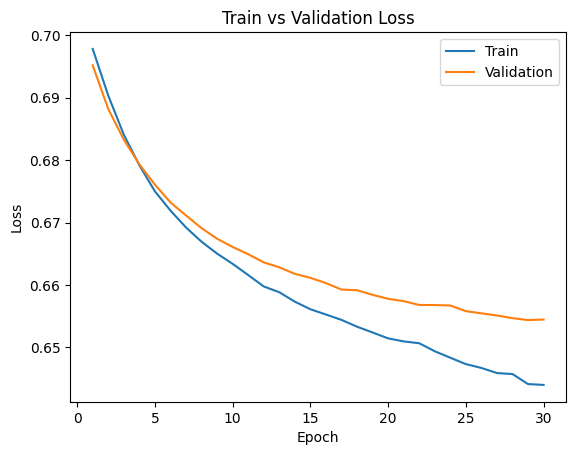

In [30]:
ANN_net = ANN()
train_net(ANN_net, batch_size=512, learning_rate=0.001)

ANN_model_path = get_model_name("ANN", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(ANN_model_path)

In [31]:
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=512)

criterion = nn.BCEWithLogitsLoss()
testError, testLoss = evaluate(ANN_net, test_loader, criterion)

print("The error rate on the test set is ", testError)
print("The loss on the test set is ", testLoss)

Files already downloaded and verified
Files already downloaded and verified
The error rate on the test set is  0.378
The loss on the test set is  0.6475991904735565


For my best CNN the error on the test set is 0.424 and the test set error is 0.684.

The 2-layer ANN model coded above yields a test error of 0.378 and test set of 0.648.

The ANN's error is lower than the CNN's.